# Bootstrapping

<div>
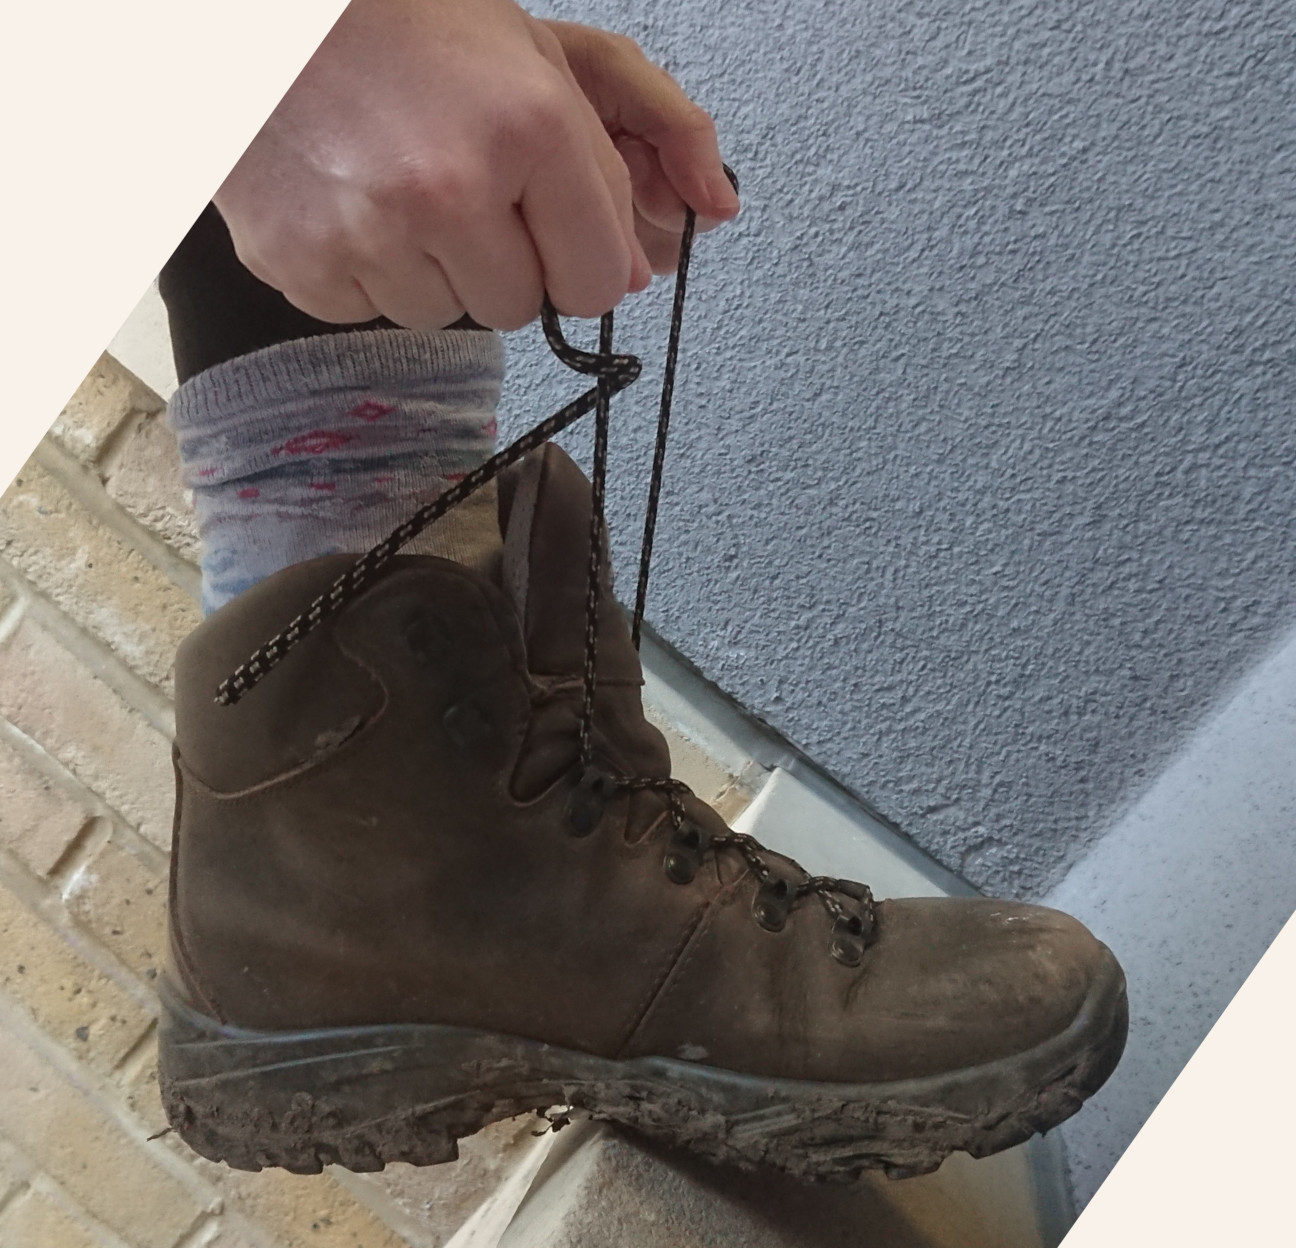
</div>

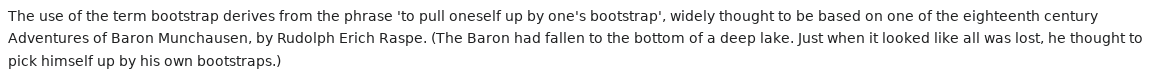
\- An Introduction to the bootstrap, Efron and Tibshirani, 1994


# Plug in estimates
* parameters as functions of population
* statistics as estimates of parameters from samples
* plug-in estimate: estimating statistic by using sample as if it was population; for example mean and uncorrected variance. Often histogram implicitly assumed to represent population.
* standard error: the standard deviation on a statistic estimated from the population using a given sample size
* bootstrapping: estimating standard error (and other uncertainties) by plug-in estimation from the sample: pretend the sample is the population, sample with replacement.
* Looks a bit like permutation testing, but different approach (sampling with replacement versus randomly exchanging data) and aims (estimating uncertainty of estimates, versus testing null hypothesis).

# Demo with TIV dataset

This is a dataset of total intracranial volume (/ml) measures on scans, each observation is an image. We are interested in three columns: `man` are manual measures of TIV, `spm12_mwc` and `fs5` are automated measures. The manual measures have been found to be quite accurate, we would like to evaluate the more variable automated measures against them. We could compare means and coefficients of regression, but as this is often used as a nuisance covariate, the $R^2$ value indicating how much of the variance is retained is particularly of interest.

In [1]:
suppressPackageStartupMessages({
    library(foreign) # reading stata dataset
    library(dplyr)# table manipulation
    })
# read the TIV data
mydata <- read.dta("comparison_TIV_all_resp_2.dta")
mydata <- filter(mydata,!is.na(man))
head(mydata)

,study,man,fs5,spm12_mwc,man_bvol,spm12_bvol,merge_bvol,spm12_unmask,spm12_jacob,merge_spm12_extras,...,m_spm8_olds,m_fs5fix,d_fs5drop3000,m_fs5drop3000,fs5drop3000,m_spm12_alad3,d_d_spm12_mwc_alad3,c_auto,g_high,g_High
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,96,1345.541,1497.891,1353.598,995.3,972.0,matched (3),1430.99,1375.66,matched (3),...,1632.578,1421.716,152.350,1421.716,1497.891,1352.802,-6.4643555,1919.616,NA,
2,98,1381.081,1436.819,1359.308,951.8,872.5,matched (3),1412.43,1386.10,matched (3),...,1491.942,1408.950,55.738,1408.950,1436.819,1369.801,0.7862549,1602.803,NA,
3,100,1285.623,1268.764,1265.084,876.8,818.2,matched (3),1346.90,1275.86,matched (3),...,1332.997,1277.193,-16.859,1277.193,1268.764,1276.248,-1.7899170,1380.372,NA,
4,102,1574.595,1680.504,1557.601,1144.1,1103.0,matched (3),1590.86,1612.16,matched (3),...,1742.638,1627.550,105.909,1627.550,1680.504,1563.436,5.3244629,1910.681,NA,
5,104,1182.910,1172.865,1170.121,776.8,698.5,matched (3),1189.42,1220.81,matched (3),...,1285.198,1177.887,-10.045,1177.887,1172.865,1176.207,0.6179199,1387.486,NA,
6,106,1408.842,1500.151,1391.574,944.3,888.2,matched (3),1474.06,1406.40,matched (3),...,1554.689,1454.496,91.309,1454.496,1500.151,1398.320,3.7767334,1700.536,NA,


## Regression model
Just getting regression coefficients and $R^2$ from a linear regression model for the two sets of values:

In [2]:
model.mwc <- lm(spm12_mwc~man,mydata) # linear model
print(model.mwc)
sprintf("Rsquared=%f",summary(model.mwc)$r.squared) # Don't want all of summary
model.fs5 <- lm(fs5~man, mydata)
print(model.fs5)
sprintf("Rsquared=%f",summary(model.fs5)$r.squared)


Call:
lm(formula = spm12_mwc ~ man, data = mydata)

Coefficients:
(Intercept)          man  
     1.5103       0.9707  



[1] "Rsquared=0.940316"


Call:
lm(formula = fs5 ~ man, data = mydata)

Coefficients:
(Intercept)          man  
   -345.260        1.289  



[1] "Rsquared=0.460257"

## Defining our bootstrap statistic
The values are quite different, but how good is our estimate of that difference? This is where the bootstrap is useful. The `boot` function will do most of the work, but we need to define the statistic we want to bootstrap.

In [3]:
library(boot) # Library for bootstrapping functions, investigate ?boot

# required arguments of boot: function (data, statistic, R)
# data : data frame to sample from
# statistic : function that calculates the statistic or statistics to bootstrap
# R : number of repetitions

# Step 1: define a function that returns our statistic of interest:
# the difference in R values. It will take a data frame and sampling
# indices:
diffR2 <- function(thisdata, set){
    model.mwc <- lm(spm12_mwc~man,thisdata[set,])
    model.fs5 <- lm(fs5~man, thisdata[set,])
    # By default R functions return the last value:
    summary(model.mwc)$r.squared - summary(model.fs5)$r.squared
}

## Running the bootstrap
At a minimum we have to supply the data, a function to calculate our statistic (or statistics) and the number of repetitions:

In [4]:
# Step 2: try bootstrapping it, will take a few seconds
bootstrap.diffR2.1000 <- boot(mydata, diffR2, 1000)

In [5]:
# Just printing it will give the estimate (from original sample)
# and bootstrap standard error and bias estimates
bootstrap.diffR2.1000


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = diffR2, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.4800598 -0.07614866   0.1394873

In [6]:
# But if we want to extract them, we'll have to calculate them ourselves!
names(bootstrap.diffR2.1000)

[1] "t0"        "t"         "R"         "data"      "seed"      "statistic"
 [7] "sim"       "call"      "stype"     "strata"    "weights"

## Calculating from the bootstrap
The print function for the bootstrap object reports the sample value of the statistic, the bootstrap bias and the standard error. However the object doesn't contain them, so we need to calculate them ourselves if we want to use them later. Fortunately they're trivial. The following function shows how to derive them, and produces a tidier summary that will be useful later.

In [7]:
makesummary <- function(somebootstrap) {
  se.est <- sd(somebootstrap$t) # t is all the sampled statistics
  original <- somebootstrap$t0 # t0 value from original sample
  bias.est <- mean(somebootstrap$t) - original # the mean of bootstraps doesn't necessarily equal sample estimate!
  data.frame(original=original, bias=bias.est, std.err = se.est,
            row.names=substitute(somebootstrap))
    # bit of R-trickery at the end to get the argument name
}
summary.1000 <- makesummary(bootstrap.diffR2.1000)
summary.1000

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000,0.4800598,-0.07614866,0.1394873


## Confidence intervals

Getting the standard error is the most basic use of the bootstrap, and really only needs a few hundred iterations. We could calculate a z-value for the difference now, and use it to calculate a p-value for the difference, but this assumes normality of the statistic samples. Besides, it would be interesting to see the confidence intervals. The three most simple are normal (assumes normality), basic (just use the histogram, actually prone to bias) and percentile (similar to basic but reversed).

In [8]:
boot.ci(bootstrap.diffR2.1000, type=c("norm","basic","perc"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.1000, type = c("norm", "basic", 
    "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.2828,  0.8296 )   ( 0.4081,  0.8394 )   ( 0.1207,  0.5520 )  
Calculations and Intervals on Original Scale

There are two other common approaches, Studentized, which is a bit more complicated to apply (we need standard error estimates from each bootstrap sample), but builds a t-distribution for the data, which is quite reliable, and Bias-corrected-accelerated (BCa), this takes some more additional calculation and quite a lot of memory (it needs to store R * sample size elements), but requires least worrying. Using 'boot.ci' without type attempts to calculate them all:

In [9]:
boot.ci(bootstrap.diffR2.1000)

Warning message in boot.ci(bootstrap.diffR2.1000):
“bootstrap variances needed for studentized intervals”


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.1000)

Intervals : 
Level      Normal              Basic         
95%   ( 0.2828,  0.8296 )   ( 0.4081,  0.8394 )  

Level     Percentile            BCa          
95%   ( 0.1207,  0.5520 )   ( 0.1487,  0.5731 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable

So we're done.

Or maybe we should worry about that warning about unstable intervals?

Here's what we should have done earlier:

## Checking bootstrap outputs

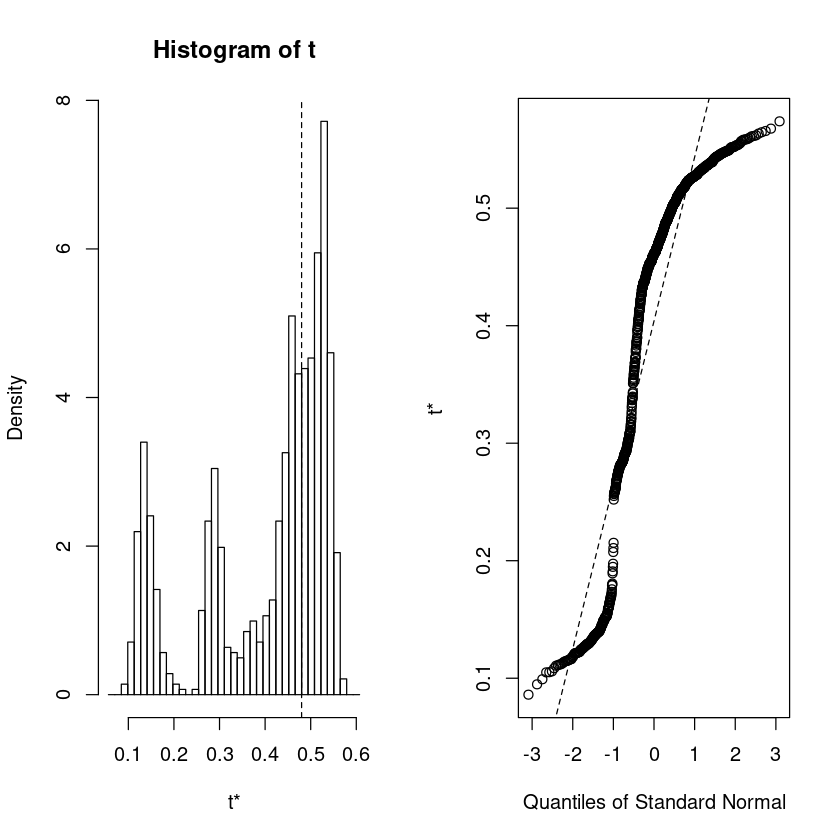

In [10]:
plot(bootstrap.diffR2.1000)

This shows the distribution of our statistic across bootstrap samples. That distribution looks very unpleasant.

The bootstrap is quite good, but should we worry about outliers? Two options:

1. We could use a more robust statistic. The ability to estimate standard error on the median rather than the mean is often used to demonstrate the bootstrap, but we really want to investigate R^2.
2. What we should have done at the start; look at the data!

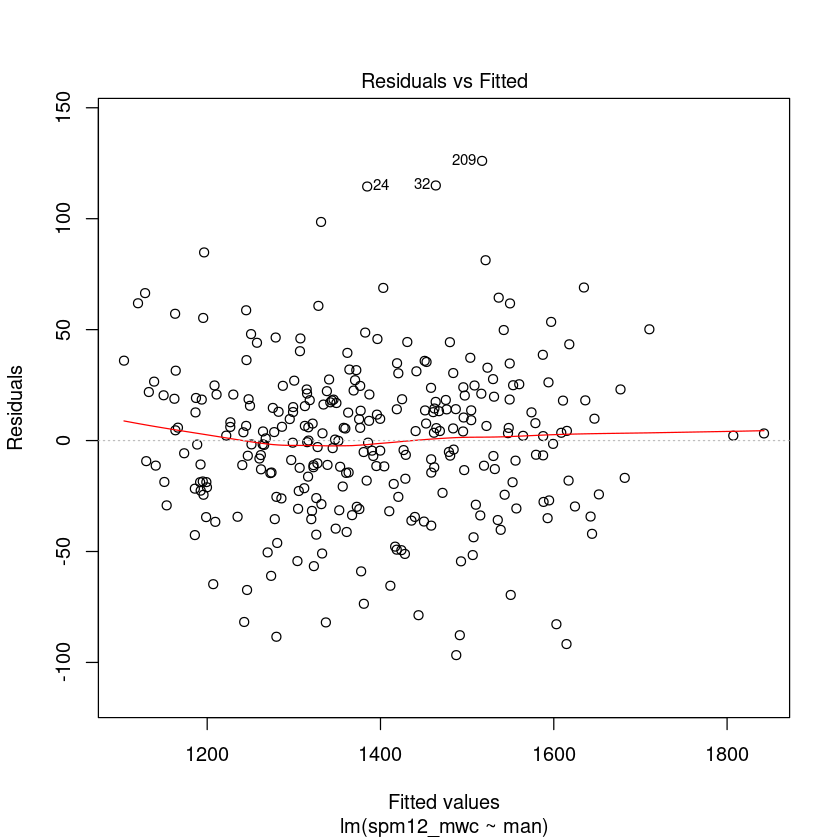

In [11]:
plot(model.mwc,which=1)

Not too bad...

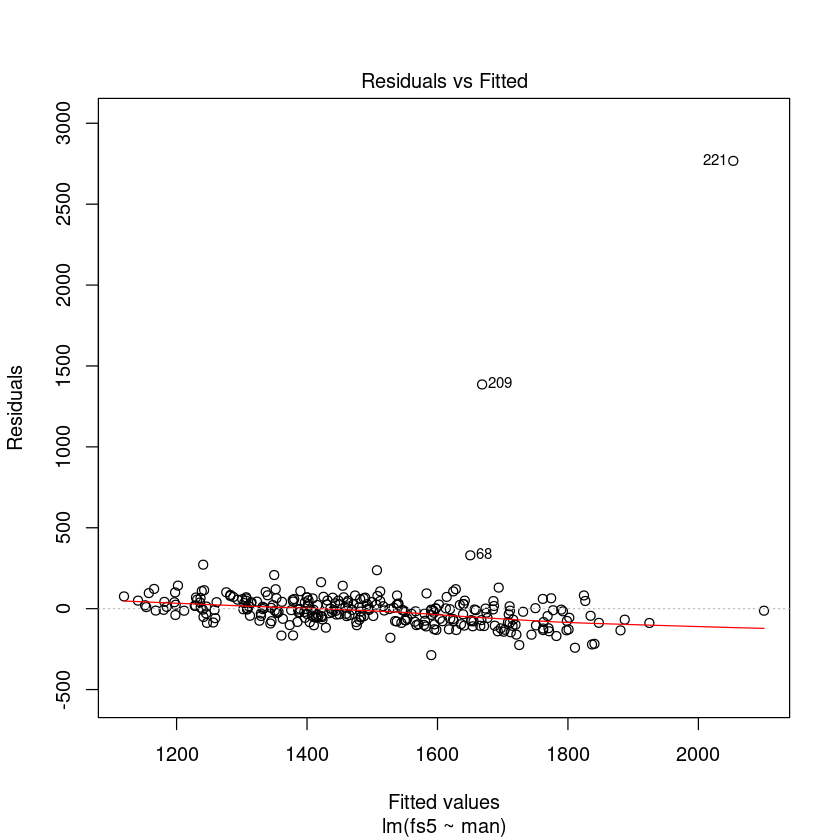

In [12]:
plot(model.fs5,which=1)

Ah... These two fs5 TIV (rows 209, 221) were estimated at >3000ml. QC showed they were misregistrations. Let's get rid of them.

In [13]:
mycleandata <- filter(mydata, fs5<3000)
bootstrap.diffR2.1000.clean <- boot(mycleandata, diffR2, 1000)

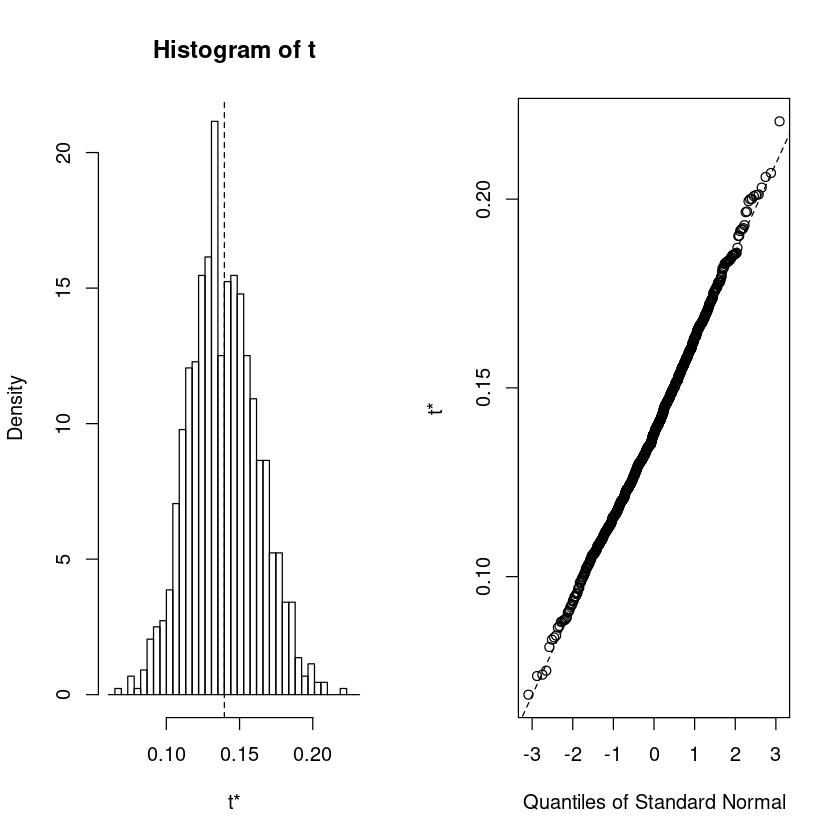

In [14]:
plot(bootstrap.diffR2.1000.clean)

Better! And the estimates?

In [15]:
# New one
summary.1000.clean <- makesummary(bootstrap.diffR2.1000.clean)
rbind(summary.1000.clean,summary.1000)

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000.clean,0.1396005,-0.0006144799,0.02347885
bootstrap.diffR2.1000,0.4800598,-0.0761486591,0.13948733


Big drop in the difference (because $R^2$ for fs5 has increased a lot), but also much smaller bias and standard error of the estimate. Let's try the confidence intervals.

In [16]:
boot.ci(bootstrap.diffR2.1000.clean)

Warning message in boot.ci(bootstrap.diffR2.1000.clean):
“bootstrap variances needed for studentized intervals”


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.1000.clean)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0942,  0.1862 )   ( 0.0939,  0.1846 )  

Level     Percentile            BCa          
95%   ( 0.0946,  0.1853 )   ( 0.1007,  0.1947 )  
Calculations and Intervals on Original Scale

They're now much closer in agreement, and still show a significant difference in the two $R^2$. 

**Given the choice the BCa is the one to use.** (or see ABC in the bonus section) But there's one more thing to fix...

## Parallelism
While 1000 iterations would be fine for a standard error estimate, it's a bit too low for a confidence interval estimate (we need more in the tails). About 10000 should be enough, but it will take my computer a while. Fortunately bootstrapping is very parallel-processing friendly.

In [17]:
bootstrap.diffR2.10000.clean <- boot(mycleandata, diffR2, 10000, parallel="multicore", ncpus=4)

In [18]:
summary.10000.clean <- makesummary(bootstrap.diffR2.10000.clean)
summary.all3 <- rbind(summary.1000, summary.1000.clean, summary.10000.clean)
summary.all3

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000,0.4800598,-0.0761486591,0.13948733
bootstrap.diffR2.1000.clean,0.1396005,-0.0006144799,0.02347885
bootstrap.diffR2.10000.clean,0.1396005,-0.0004707032,0.02323582


Good to see bias reducing with increased iterations, suggests mostly sampling, rather than systematic. Trying confidence intervals, this will take a while...

In [19]:
bootstrap.diffR2.10000.clean.ci <- boot.ci(bootstrap.diffR2.10000.clean)
bootstrap.diffR2.10000.clean.ci

Warning message in boot.ci(bootstrap.diffR2.10000.clean):
“bootstrap variances needed for studentized intervals”


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap.diffR2.10000.clean)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0945,  0.1856 )   ( 0.0918,  0.1826 )  

Level     Percentile            BCa          
95%   ( 0.0966,  0.1874 )   ( 0.1011,  0.1938 )  
Calculations and Intervals on Original Scale

The published 95% BCa interval for this data is [0.101, 0.194] (using Stata)

## P-values
Speaking of Stata... if you use Stata you will also get z-values and p-values alongside your confidence intervals. These appear to be calculated from the standard error under normality assumption; z as the ratio of statistic to standard error, p as the two-sided tails of the Normal distribution on z.

Here's what Stata is probably doing:

In [20]:
summary.all3$z <- summary.all3$original / summary.all3$std.err
summary.all3$p <- 2 * (1-pnorm(abs(summary.all3$z)))
summary.all3

,original,bias,std.err,z,p
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bootstrap.diffR2.1000,0.4800598,-0.0761486591,0.13948733,3.441601,5.782821e-04
bootstrap.diffR2.1000.clean,0.1396005,-0.0006144799,0.02347885,5.945797,2.751153e-09
bootstrap.diffR2.10000.clean,0.1396005,-0.0004707032,0.02323582,6.007986,1.878420e-09


 You could alternatively try to use the bootstrap distribution tails for this, however bootstrap tests are not the same as permutation tests and there is the issue of bias. We could permutation test too of course, although in marginal cases it may not agree perfectly with the bootstrap intervals.

## Repeatability

Because bootstrapping uses random samples, it will be slightly different every time.

In [21]:
boot1<-boot(mycleandata, diffR2, 1000)
boot2<-boot(mycleandata, diffR2, 1000)
rbind(makesummary(boot1),makesummary(boot2))

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
boot1,0.1396005,0.0003489644,0.02276301
boot2,0.1396005,0.0002688068,0.02319239


If we need to re-generate the same sampling we can set the random seed.

In [22]:
newseed <- sum(as.integer(charToRaw("2020 is over")))
set.seed(newseed)
boot3<-boot(mycleandata, diffR2, 1000)
set.seed(newseed)
boot4<-boot(mycleandata, diffR2, 1000)
rbind(makesummary(boot3),makesummary(boot4))

,original,bias,std.err
,<dbl>,<dbl>,<dbl>
boot3,0.1396005,-0.0005999831,0.02292003
boot4,0.1396005,-0.0005999831,0.02292003


## Multiple parameters

It's possible to estimate more than one parameter at a time. Let's leave $R^2$ and look at the regression coefficients themselves.

In [23]:
model.mwc$coefficients

(Intercept)         man 
  1.5102840   0.9706556

These are our sample estimates. Of course there's a standard estimate for the se of the regression coefficients.

In [24]:
summary(model.mwc)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.5102840,20.75304366,0.0727741,9.420368e-01
man,0.9706556,0.01446016,67.1262203,4.305247e-177


But can we bootstrap it? We need to define a function, this is simpler than last time, as we just need to report back the model coefficients.

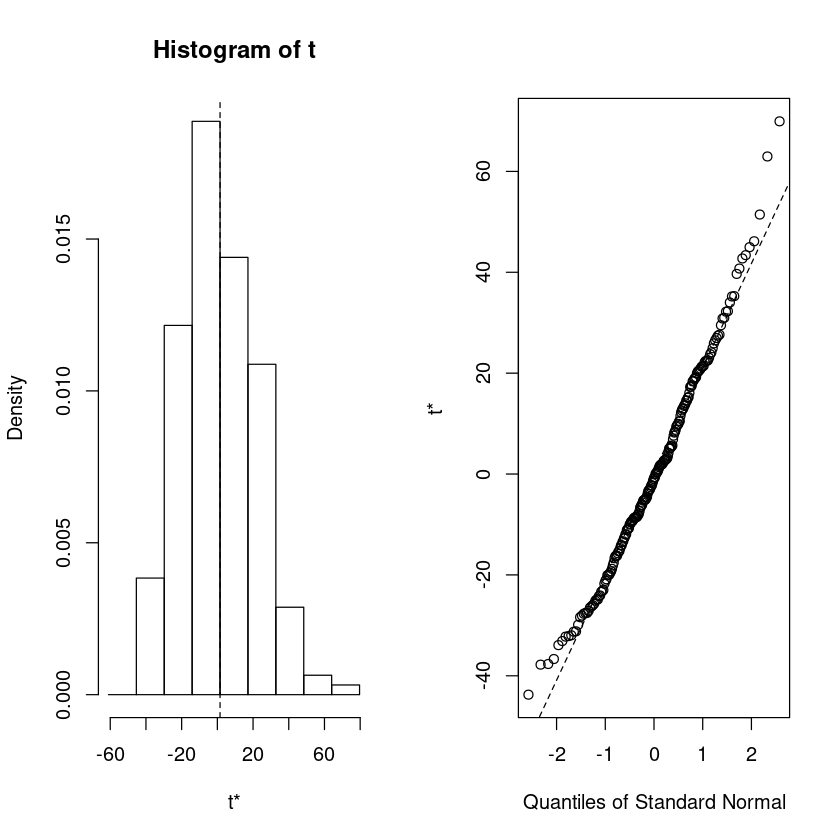

In [25]:
regressCoeffs <- function(thisdata,set){
    thismodel <- lm(spm12_mwc ~ man, thisdata[set,])
    thismodel$coefficients
}
# model.mwc was done without the fs5 outliers removed, so let's stick with that
regress.boot <- boot(mydata, regressCoeffs, 200)
plot(regress.boot)

Looks fine for the first statistic, what about the other? We need to tell plot which one using `index` (default 1):

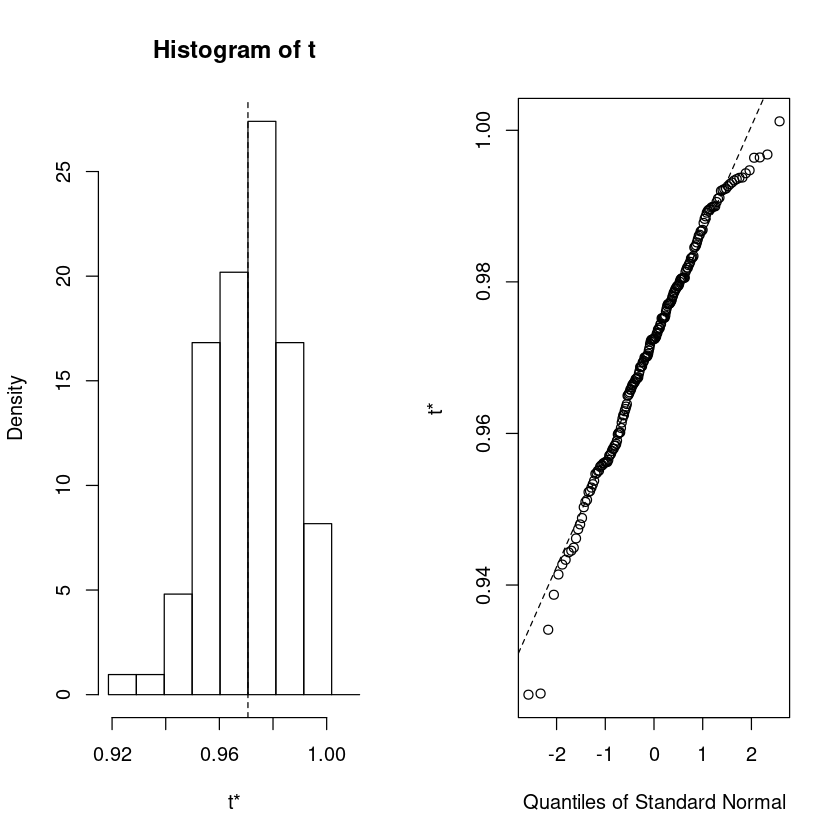

In [26]:
plot(regress.boot,index=2)

In [27]:
regress.boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mydata, statistic = regressCoeffs, R = 200)


Bootstrap Statistics :
     original       bias    std. error
t1* 1.5102840 -1.081846340 20.65595811
t2* 0.9706556  0.000824199  0.01454571

In [28]:
summary(model.mwc)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.5102840,20.75304366,0.0727741,9.420368e-01
man,0.9706556,0.01446016,67.1262203,4.305247e-177


Not bad.

### A warning!

In [29]:
boot.ci(regress.boot,type=c("perc","norm","stud"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 200 bootstrap replicates

CALL : 
boot.ci(boot.out = regress.boot, type = c("perc", "norm", "stud"))

Intervals : 
Level      Normal            Studentized          Percentile     
95%   (-37.893,  43.077 )   (-42.581,  36.506 )   (-33.900,  44.932 )  
Calculations and Intervals on Original Scale
Some studentized intervals may be unstable
Some percentile intervals may be unstable

We've got studentized intervals now? **No we don't.**

If the statistic function returns two statistics then by default `boot.ci` assumes the second is the standard error estimate for the first. This is convenient if that's what you're doing, otherwise watch out for claimed Studentized intervals that aren't.

## Sampling
There is not necessarily just one way to sample from a population. In the TIV data we had data [$manual_i$, $spm_i$, $fs5_i$], and drew independent samples from these as a joint distribution. However, in a situation where we had chosen the measurement points (say our TIV were simulated volumes which we chose to distribute over a range), then we may not want to sample randomly the independent variables.

In this case we might instead sample from residuals, by first fitting some model: $y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

We can then calculate the residuals $\epsilon_i = y_i - \hat \beta_0 + \hat \beta_1 x_i$ ($\hat\beta_j$ are the estimated values)


And resample from $\epsilon_i$ to $\epsilon_i^*$, then calculate $y_i^* = \hat\beta_0 + \hat\beta_1 x_i + \epsilon_i^*$ and proceed to calculate our statistic on this data.

The only change required is that our function performs a different calculation (and for efficiency we should pre-compute residuals, in fact the model object already has them, ```model.mwc$residuals```). Bootstrapping on residuals is more sensitive to assumptions than bootstrapping on observations.

The rule of thumb is to try to have the bootstrap sampling replicate the data collection.

# More complicated sampling

In the TIV example we are sampling from a single set of observations. This might not always be the case. In the residuals example we already have a slightly more complex example, as the plug-in distribution contains estimates of the $\beta_j$ as well as the observed residuals $\epsilon_i$.

But what if we have two groups? We could have a group variable and sample as if from a single population, however the resulting estimate would include variance in the group membership as well.

What we have to do is identify that our bootstrap sample will be drawn from more than one population.

## Placebo vs control
Say we've got vaccine data, 14000 people on treatment, and 14000 on placebo. After some interval there are 8 infections in the treatment group and 86 in the placebo group. How effective is it? What is the uncertainty on that estimate?

In [30]:
# Risk ratio :
armsize <- 14000
inf.vacc <- 8
inf.plac <- 86
rr <- (inf.vacc/armsize) / (inf.plac/armsize)
effic <- 1-rr
print(paste(100*c(rr, effic)))

[1] "9.30232558139535" "90.6976744186046"


That's to say ~9% of the infection rate in treatment compared to placebo, or ~91% efficacy. As the situation is binomial there's actually an analytical estimate for the uncertainty:

In [31]:
library(fmsb)
rr.est <- riskratio(inf.vacc,inf.plac,armsize,armsize)
rr.est

           Disease Nondisease Total
Exposed          8      13992 14000
Nonexposed      86      13914 14000



	Risk ratio estimate and its significance probability

data:  inf.vacc inf.plac armsize armsize
p-value = 6.661e-16
95 percent confidence interval:
 0.04509461 0.19189269
sample estimates:
[1] 0.09302326


Again, subtract from 1 to convert to efficacy

In [32]:
100*(1-rr.est$conf.int)
rev(100*(1-rr.est$conf.int)) # more conventional way around

[1] 95.49054 80.81073
attr(,"conf.level")
[1] 0.95

[1] 80.81073 95.49054

So, we don't need bootstrapping here. But it would be a useful example to look at group comparisons, however, the very big sample is a problem, it takes longer to create these samples. Fortunately the uncertainty is relatively independent of arm size so long as they're a lot bigger than the case numbers:

In [33]:
smallarm <- 1000
rr.est.small <- riskratio(inf.vacc,inf.plac,smallarm,smallarm)
rr.est.small.ci <- rev(100*(1-rr.est.small$conf.int))
rr.est.small

           Disease Nondisease Total
Exposed          8        992  1000
Nonexposed      86        914  1000



	Risk ratio estimate and its significance probability

data:  inf.vacc inf.plac smallarm smallarm
p-value = 2.22e-16
95 percent confidence interval:
 0.04531807 0.19094648
sample estimates:
[1] 0.09302326


## Create sample data
We create the observations, they're quite simply outcome (no infection/infection) and group membership (placebo/vaccine)

In [34]:
vacctrial <- data.frame(outcome=c(rep(1,inf.plac),rep(0,smallarm-inf.plac),rep(1,inf.vacc),rep(0,smallarm-inf.vacc)), group=c(rep(0,smallarm),rep(1,smallarm)))
head(vacctrial)
tail(vacctrial)
table(vacctrial)

,outcome,group
,<dbl>,<dbl>
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0


,outcome,group
,<dbl>,<dbl>
1995,0,1
1996,0,1
1997,0,1
1998,0,1
1999,0,1
2000,0,1


       group
outcome   0   1
      0 914 992
      1  86   8

## Define our statistic
This is just the efficacy rate above. This function needs to be run each bootstrap, so it's worth trying to make it efficient.

In [35]:
effrate <- function(d,set) {
   samp <- d[set,]
   place <- samp[samp$group==0,]
   treat <- samp[samp$group==1,]
   effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
   effrate
 }
effrate(vacctrial)

[1] 0.9069767

## Stratified bootstrap time!
Notice we now give the `boot()` function a `strata` argument. This tells it the sample contains different subgroups which should be sampled independently. Each bootstrap sample will take the group0 samples from group 0 and group 1 samples from group 1.

In [36]:
boot.risk.1000 <- boot(vacctrial,effrate, 1000, strata=vacctrial$group)

Notice that both the statistic (effrate) and the bootstrap make use of group. effrate needs it to calculate determine which samples are in which group for its calculation, strata needs it to know how the samples should be divided.

In [37]:
boot.risk.1000


STRATIFIED BOOTSTRAP


Call:
boot(data = vacctrial, statistic = effrate, R = 1000, strata = vacctrial$group)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.9069767 -0.001384855  0.03378436

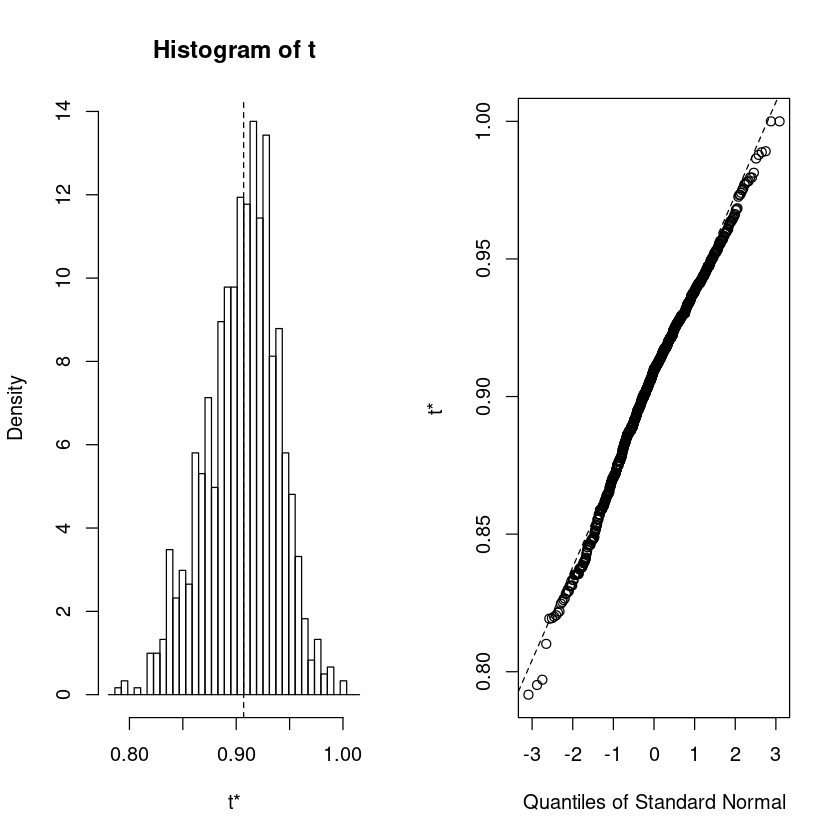

In [38]:
plot(boot.risk.1000)

In [39]:
boot.ci(boot.risk.1000,type=c("norm","basic","perc"))

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot.risk.1000, type = c("norm", "basic", 
    "perc"))

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.8421,  0.9746 )   ( 0.8488,  0.9788 )   ( 0.8352,  0.9651 )  
Calculations and Intervals on Original Scale

We expected:

In [40]:
rr.est.small.ci

[1] 80.90535 95.46819

The basic bootstrap is badly biassed, the Normal boostrap is also overoptimistic as it doesn\'t handle the skew. The percentile bootstrap is a bit better. Let's try BCa:

In [41]:
try( # catch the error when it doesn't work
    boot.ci(boot.risk.1000,type=c("bca"))
    )

Error in bca.ci(boot.out, conf, index[1L], L = L, t = t.o, t0 = t0.o,  : 
  estimated adjustment 'a' is NA


BCa fails because we don't have enough bootstrap estimates, we actually need more than there are elements in the sample. In any case, we had less replicates than we said were needed for confidence intervals anyway. Let's try again.

In [42]:
boot.risk.10000 <- boot(vacctrial,effrate, 10000, strata=vacctrial$group, parallel = "multicore", ncpus = 4)

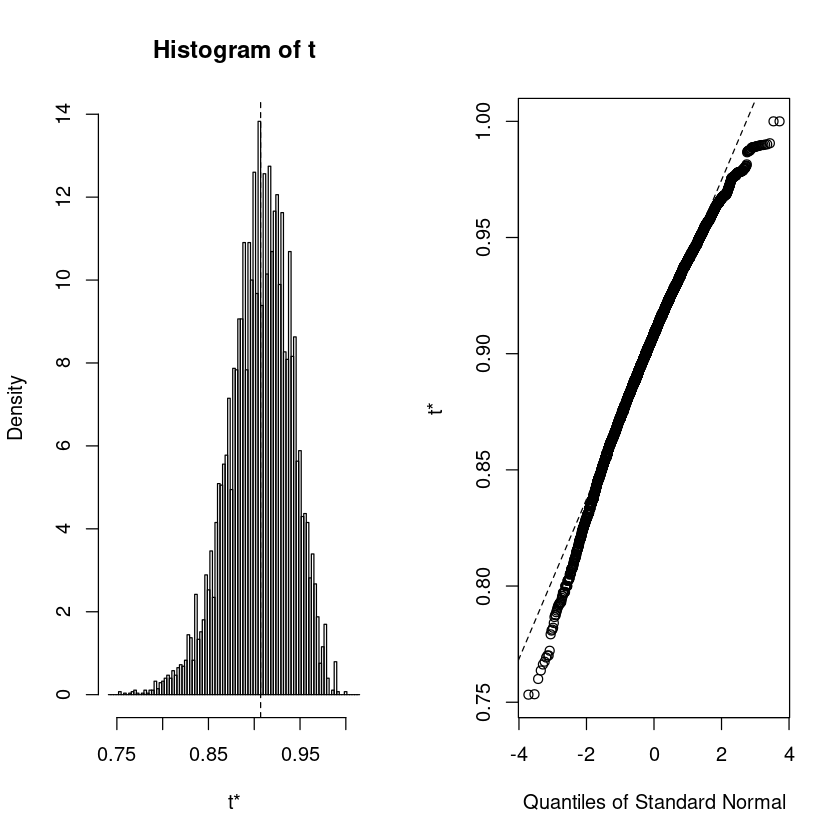

In [43]:
plot(boot.risk.10000)

Skew in the tails is much clearer now. Let's try again, this will take a while, so we'll store the result. It'd be interesting to know how long it takes too...

In [44]:
system.time(boot.risk.10000.ci <- boot.ci(boot.risk.10000,type=c("norm","basic","perc","bca")))

   user  system elapsed 
116.170   1.116 118.919 

(We'd have probably benefitted from 20000 iterations, but I'm not sure I wanted this to take longer in a demonstration.)

In [45]:
boot.risk.10000.ci

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot.risk.10000, type = c("norm", "basic", 
    "perc", "bca"))

Intervals : 
Level      Normal              Basic         
95%   ( 0.8406,  0.9752 )   ( 0.8480,  0.9830 )  

Level     Percentile            BCa          
95%   ( 0.8310,  0.9659 )   ( 0.8153,  0.9595 )  
Calculations and Intervals on Original Scale

In [46]:
# and again our analytic result:
rr.est.small.ci

[1] 80.90535 95.46819

The BCa does pretty well, it does take a while here, but not prohibitively long.

## Accessing confidence intervals
We might want to get at those confidence interval values, if we've assigned the `boot.ci` result to an object then they're stored in the corresponding names:

In [47]:
names(boot.risk.10000.ci)

[1] "R"       "t0"      "call"    "normal"  "basic"   "percent" "bca"

Although how they're stored is a little inconsistent:

In [48]:
boot.risk.10000.ci$normal
#boot.risk.10000.ci$basic # don't use it
boot.risk.10000.ci$percent
boot.risk.10000.ci$bca

conf,,
0.95,0.8406103,0.9752486


conf,,,,
0.95,250.03,9750.98,0.8309859,0.9659091


conf,,,,
0.95,113.51,9554.57,0.8153034,0.9594595


For Normal, we just have the confidence level (95%) and the confidence intervals (`[2:3]`), for the others there are extra elements relating to the percentile locations, confidence intervals still come at the end (`[4:5]`)

<div>
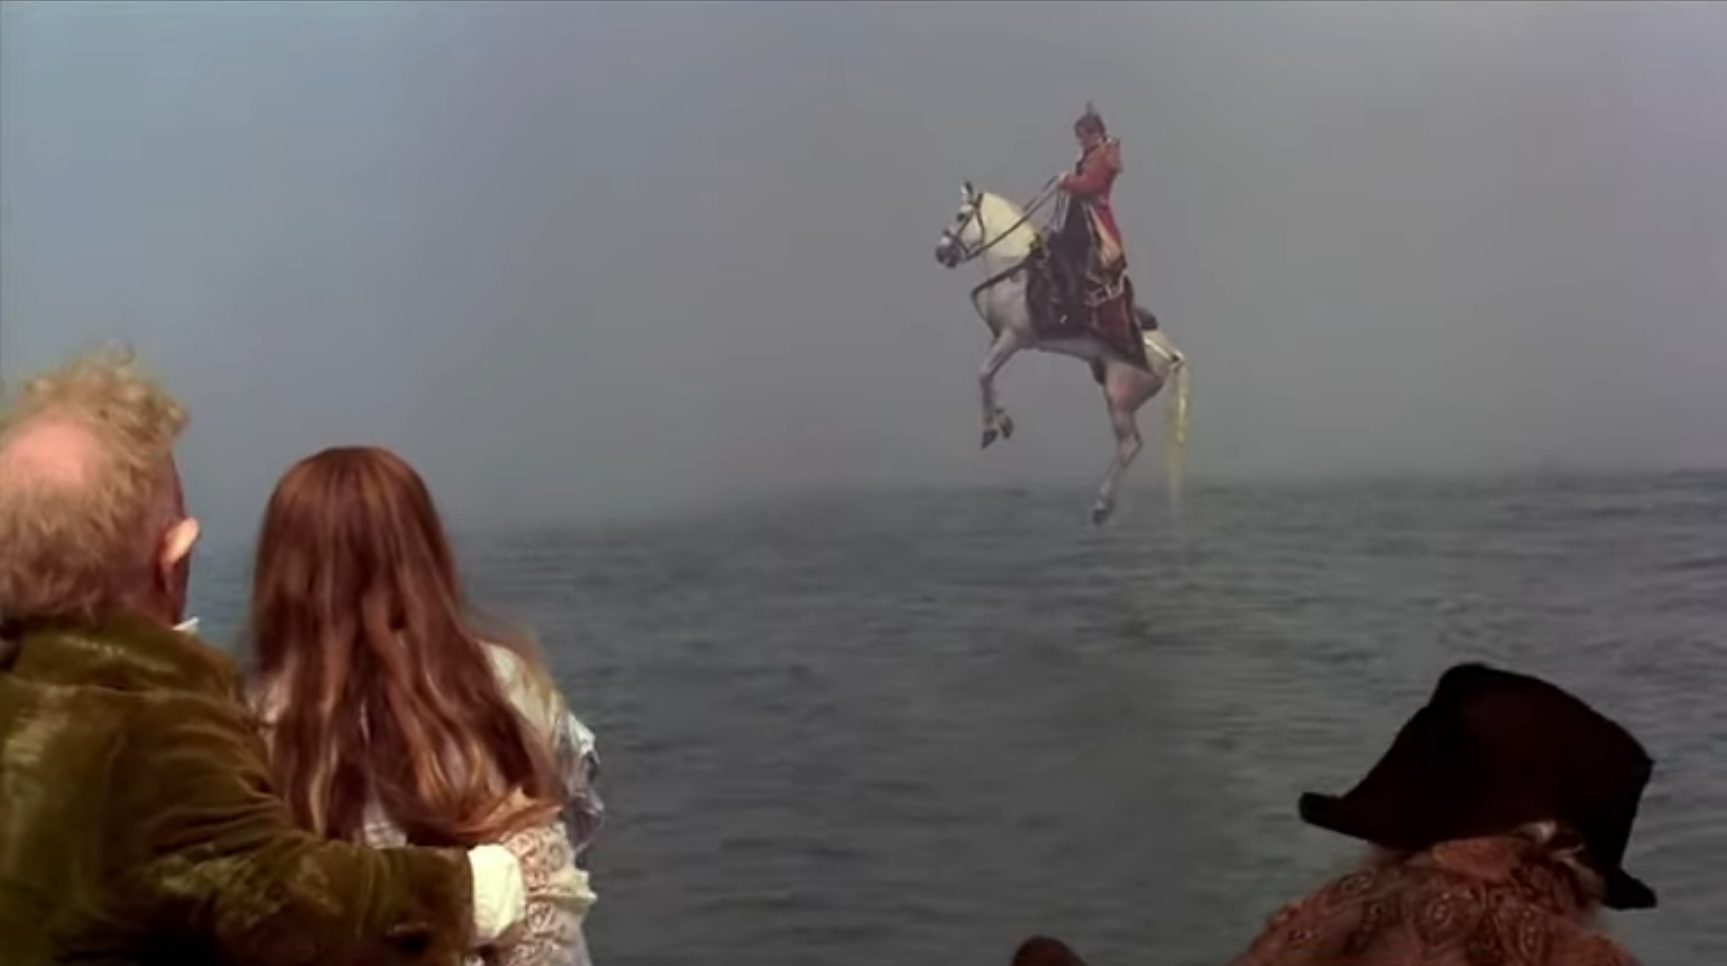
</div>

\- John Neville demonstrates, The Adventures of Baron Munchausen, Gilliam, 1988

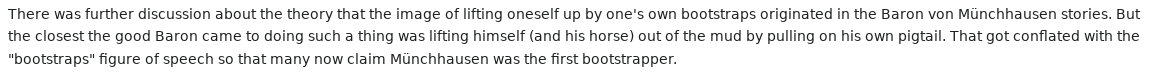
\- Lexicographer Ben Zimmer quoted in Boston Globe Ideas, Jan Freeman, 2009

## Further reading
References used for this workshop:
* Efron and Tibshirani, An Introduction to the Bootstrap
* Carpenter and Bithell, Statist.Med. 2000, https://www.tau.ac.il/~saharon/Boot/10.1.1.133.8405.pdf
* Hesterberg, Am Stat 2015 https://pubmed.ncbi.nlm.nih.gov/27019512/ (actually the more irreverent arXiv version https://arxiv.org/abs/1411.5279)

# Bonus content

## Inside stratification bonus
Say we don't trust stratification, let's make a function that looks inside:

In [49]:
effratenosy <- function(d,set) {
   samp <- d[set,]
   place <- samp[samp$group==0,]
   treat <- samp[samp$group==1,]
   print(paste(nrow(place),nrow(treat))) # report our group sizes
   effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
   effrate
 }


Running a tiny bootstrap, we see that with the balanced arms, each group has the same numbers. (If we randomly sampled across groups this would vary a bit.)

In [50]:
boot(vacctrial,effratenosy, 10, strata=vacctrial$group)

[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"
[1] "1000 1000"



STRATIFIED BOOTSTRAP


Call:
boot(data = vacctrial, statistic = effratenosy, R = 10, strata = vacctrial$group)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.9069767 -0.006460657  0.02642444

Let's create a slightly imbalanced study:

In [51]:
smallarmB <- smallarm+1
vacctrialImb <- data.frame(outcome=c(rep(1,inf.plac),rep(0,smallarm-inf.plac),rep(1,inf.vacc),rep(0,smallarmB-inf.vacc)), group=c(rep(0,smallarm),rep(1,smallarmB)))
table(vacctrialImb)


       group
outcome   0   1
      0 914 993
      1  86   8

In [52]:
boot(vacctrialImb,effratenosy, 10, strata=vacctrialImb$group)

[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"
[1] "1000 1001"



STRATIFIED BOOTSTRAP


Call:
boot(data = vacctrialImb, statistic = effratenosy, R = 10, strata = vacctrialImb$group)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.9070697 0.001789022  0.03971349

## Timings bonus
It's not always clear what the most efficient route to calculation is going to be. The following are a few different ways of calculating the same statistic. They're all acceptably fast, but show a few things that may affect more complciated calculations

In [53]:
suppressPackageStartupMessages(library(data.table))

In [54]:
effratePlainR <- function(d,set) {
   samp <- d[set,]
   place <- samp[samp$group==0,]
   treat <- samp[samp$group==1,]
   effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
   effrate
 }

effratePlainRLogic <- function(d,set) {
   samp <- d[set,]
   place <- samp$group==0
   treat <- samp$group==1
   placepos <- samp$group==0 & samp$outcome==1
   treatpos <- samp$group==1 & samp$outcome==1
   effrate <- 1 - (sum(treatpos)/sum(treat))/(sum(placepos)/sum(place))
   effrate
 }

effratePlainRLogicExtreme <- function(d,set) {
   place <- d$group[set]==0
   treat <- d$group[set]==1
   placepos <- d$group[set]==0 & d$outcome[set]==1
   treatpos <- d$group[set]==1 & d$outcome[set]==1
   effrate <- 1 - (sum(treatpos)/sum(treat))/(sum(placepos)/sum(place))
   effrate
 }

effrateByTable <- function(d,set) {
  thistable <- table(d[set,])
  effrate <- 1 - (thistable["1","1"]/sum(thistable[,"1"]))/(thistable["1","0"]/sum(thistable[,"0"]))
  effrate
}

effrateByDplyr <- function(d,set) {
    samp <- d[set,]
    place <- samp %>% filter(group==0)
    treat <- samp %>% filter(group==1)
    effrate <- 1 - (sum(treat$outcome)/nrow(treat))/(sum(place$outcome)/nrow(place))
    effrate
}

effrateByDplyrTable <- function(d,set) {
    # Need to do the factor stuff to stop empty levels disappearing in summarise
    thistable <- d[set,] %>% mutate(group=factor(group),outcome=factor(outcome)) %>%
        group_by(group,outcome, .drop=FALSE) %>% summarise(n=n())
    grptable <- thistable %>% summarise(n=sum(n))
    effrate <- 1 - (filter(thistable,group==1,outcome==1)$n/filter(grptable,group==1)$n)/
        (filter(thistable,group==0,outcome==1)$n/filter(grptable,group==0)$n)
    effrate
}

effrateByDtable <- function(d,set) {
    samp <- as.data.table(d)[set,]
    place <- samp[group==0,]
    treat <- samp[group==1,]
    effrate <- 1 - (treat[,sum(outcome)]/nrow(treat))/(place[,sum(outcome)]/nrow(place))
    effrate
}

effrateOnDtable <- function(d,set) {
    samp <- d[set,]
    place <- samp[group==0,]
    treat <- samp[group==1,]
    effrate <- 1 - (treat[,sum(outcome)]/nrow(treat))/(place[,sum(outcome)]/nrow(place))
    effrate
}


In [55]:
system.time(boot.risk.1000 <- boot(vacctrial,effratePlainR, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effratePlainRLogic, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effratePlainRLogicExtreme, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByTable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByDplyr, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByDplyrTable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(vacctrial,effrateByDtable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effrateByDtable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effrateOnDtable, 1000, strata=vacctrial$group))
system.time(boot.risk.1000 <- boot(as.data.table(vacctrial),effratePlainR, 1000, strata=vacctrial$group))




   user  system elapsed 
  2.148   0.001   2.184 

   user  system elapsed 
  1.854   0.032   1.914 

   user  system elapsed 
  0.389   0.017   0.412 

   user  system elapsed 
  6.318   0.001   6.401 

   user  system elapsed 
  4.408   0.000   4.497 

   user  system elapsed 
 13.554   0.000  13.812 

   user  system elapsed 
  9.532   0.078   7.844 

   user  system elapsed 
  9.354   0.086   7.374 

   user  system elapsed 
  8.812   0.106   6.989 

   user  system elapsed 
  2.604   0.028   1.795 

First, all of these are acceptably fast to run with 10 or 20 thousand iterations. Problems are more likely to arise when bootstrapping hard-to-calculate statistics like mixed models.

Our inelegant plain-R approach is actually one of the fastest options, it minimises function calls and uses simple ones.

The logic operations approach is a little faster than the original one; there's less subsetting of data frames and creating new objects involved, but it's a little harder to read.

The extreme version of the logic operations approach is even faster, and even harder to read. By not doing `d[set,]` to explicitly create the new sample it saves time on creating a new data frame and only subsets basic vectors instead. However you might want to think twice about whether saving 15 seconds on a long bootstrap is worth the extra debugging time.

Table is a bit disappointing, this would be quite an elegant approach, probably it's doing extra work to handle more general cases.

Dplyr costs us a bit of time, although it might be a bit more readable. Attempting to use dplyr aggregation to take the table approach is about the same speed as the table approach.

data.table is often the fastest way to operate on filtering and joining data, but it seems to be slow here. (Overhead, internal conversion?). Trying to pre-convert the dataset to a data.table before the bootstrap, and even completely relying on having a data.table shows us this conversion is not the bottleneck.

Lastly, sending in a data.table to the original plain-R approach is actually a little slower (but not much).

## Studentised bootstrap
We previously ignored the studentised bootstrap. It needs a standard error estimate for each bootstrap sample. We could use it with analytic standard errors. This doesn't entirely defeat the point, since we can get better confidence intervals than relying on perfect agreement with a theoretical distribution.

But, of course, we could always calculate the standard errors with a bootstrap. This gives a nested bootstrap, here's the outer function which uses our earlier diffR2se to bootstrap for the standard error calculation.

In [56]:
diffR2se <- function(thisdata, set, R=200){
    innerboot <- boot(thisdata[set,],diffR2,R=R)
    c(r2=innerboot$t0, r2se=sd(innerboot$t))
}

You can imaging this might take a while, 200 * 10000 bootstraps, if the original example took about 20 seconds, then this will be over an hour. (Actually, we have (10000 + 1) * (200 + 1) calculations of R^2, since each bootstrap also calculates t0 for the 'original' sample.)

In [57]:
#studentboot <- boot(mycleandata, diffR2se, 10000, parallel = "multicore", ncpus = 4)
studentboot<-readRDS("studentboot.rds") # Because the workshop isn't that long...

Our previous BCa result [0.101, 0.194]

In [58]:
studentboot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = mycleandata, statistic = diffR2se, R = 10000, parallel = "multicore", 
    ncpus = 4)


Bootstrap Statistics :
      original        bias    std. error
t1* 0.13960048 -0.0001010909 0.023045906
t2* 0.02331584 -0.0007959714 0.003486338

In [59]:
studentboot.ci <- boot.ci(studentboot)
studentboot.ci

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 10000 bootstrap replicates

CALL : 
boot.ci(boot.out = studentboot)

Intervals : 
Level      Normal              Basic             Studentized     
95%   ( 0.0945,  0.1849 )   ( 0.0918,  0.1820 )   ( 0.0958,  0.1897 )  

Level     Percentile            BCa          
95%   ( 0.0972,  0.1874 )   ( 0.1014,  0.1940 )  
Calculations and Intervals on Original Scale

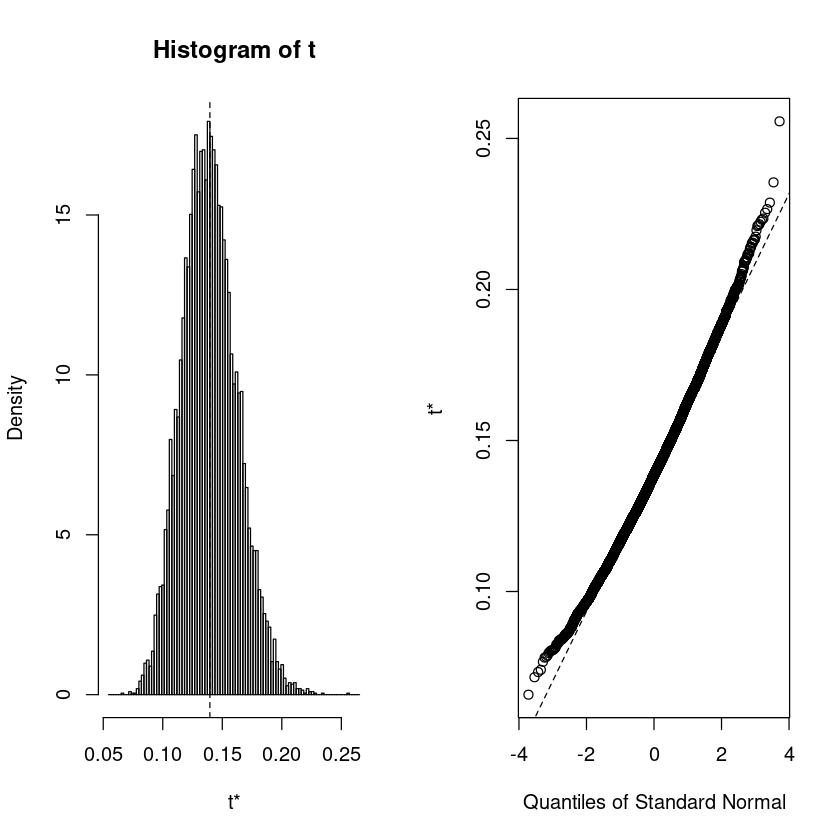

In [60]:
plot(studentboot,index=1)

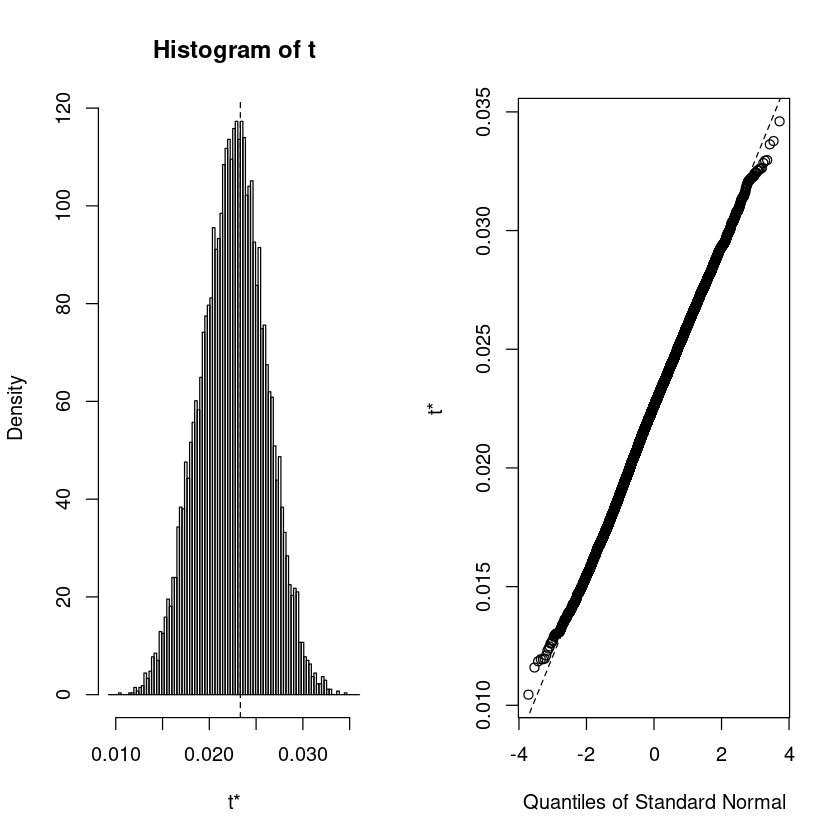

In [61]:
plot(studentboot,index=2)

In [62]:
library(ggplot2)

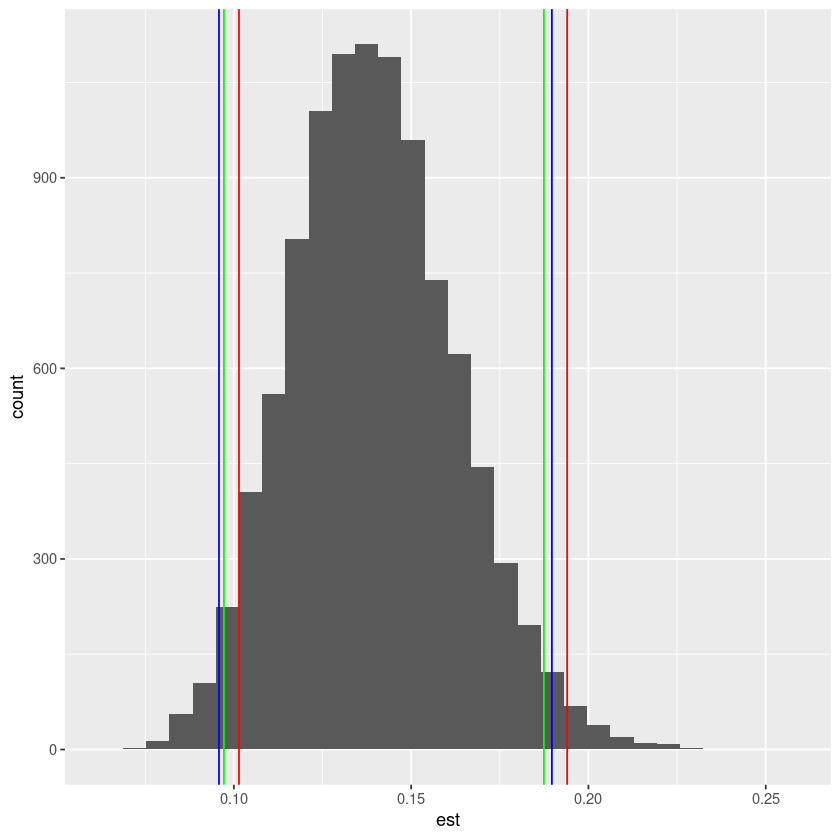

In [63]:
tees <- as.data.frame(studentboot$t)
names(tees) <- c("est","std.err")
ggplot(tees,aes(est)) + geom_histogram(bins=30) +  geom_vline(xintercept=studentboot.ci$bca[4:5], colour="red") +
 geom_vline(xintercept=studentboot.ci$student[4:5], colour="blue") +
 geom_vline(xintercept=studentboot.ci$perc[4:5], colour="green")

The studentised confidence interval deals a bit better with differing tail weights, but not so much with bias. On the other hand the BCa estimates become less stable for low $\alpha$ tails, below 0.025.

## Don't bootstrap at all!
Due to Tibshirani there is an analytical approximation to the BCa result (called ABC), but it requires a statistic that can use weights rather than resampling. This is simply done for the $R^2$ difference from the linear model:

In [64]:
diffR2weights <- function(thisdata,weights) {
    model.mwc <- lm(spm12_mwc ~ man, thisdata, weights=weights)
    model.fs5 <- lm(fs5 ~ man, thisdata, weights=weights)
    summary(model.mwc)$r.squared - summary(model.fs5)$r.squared
}

In [65]:
abc.ci(mycleandata,diffR2weights) # abc.ci is in the boot package

[1] 0.9500000 0.1014000 0.1948592

Compare our BCa result from bootstrapping:

In [66]:
bootstrap.diffR2.10000.clean.ci$bca[c(1,4,5)]

[1] 0.9500000 0.1010539 0.1938469

Much faster and gives a similar result. However we can't check what's going on behind the scenes, and can't derive standard error (though we could ask for a different confidence interval). Also will only work for statistics that can be calculated in a weighted fashion.

## Packages bootstrap vs boot
The `bootstrap` package is also available in R, it implements the functions as described in 'An Introduction to the Bootstrap', `boot` is the recommended package for new users.